In [1]:
# Cell 1 — Header, imports, observer configuration
import os, json, math
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

# astronomy libs
from skyfield.api import Loader, Topos, EarthSatellite, wgs84, utc
import astropy.units as u
from astropy.coordinates import SkyCoord

# Notebook outputs
OUTPUT_PLANET_JSON = "planet_catalog.json"
OUTPUT_MERGED_JSON = "merged_sky_catalog.json"

# Observer location (Chennai, Tamil Nadu)
OBSERVER_LAT = 13.0827
OBSERVER_LON = 80.2707
OBSERVER_ELEV_M = 6.0

print("Observer set to Chennai (lat,lon,elev):", OBSERVER_LAT, OBSERVER_LON, OBSERVER_ELEV_M)


Observer set to Chennai (lat,lon,elev): 13.0827 80.2707 6.0


In [2]:
# Cell 2 — ephemeris loader and time helpers (timezone-aware)
load_dir = os.path.join(os.getcwd(), "skyfield_data")
os.makedirs(load_dir, exist_ok=True)
loader = Loader(load_dir, expire=False)

HAS_SKYFIELD = True
try:
    eph = loader('de421.bsp')   # JPL ephemeris (small)
    ts = loader.timescale()
except Exception as e:
    print("Skyfield/ephemeris load failed:", e)
    eph = None
    ts = None
    HAS_SKYFIELD = False

def utc_now_tz():
    """Return timezone-aware UTC datetime"""
    return datetime.now(timezone.utc)

def make_time_grid(start_dt_utc, duration_hours=6, n_frames=40):
    """Return list of timezone-aware datetimes (UTC) and a Skyfield Time object array."""
    start_dt_utc = start_dt_utc.astimezone(timezone.utc)
    # create numpy seconds offsets
    seconds = np.linspace(0, duration_hours * 3600.0, n_frames)
    datetimes = [start_dt_utc + timedelta(seconds=float(s)) for s in seconds]
    # skyfield times
    sf_times = ts.utc(
        [d.year for d in datetimes],
        [d.month for d in datetimes],
        [d.day for d in datetimes],
        [d.hour for d in datetimes],
        [d.minute for d in datetimes],
        [d.second + d.microsecond/1e6 for d in datetimes]
    )
    return datetimes, sf_times

print("Skyfield available:", HAS_SKYFIELD)


Skyfield available: True


In [3]:
# Cell 3 — compute planet positions (robust Skyfield + synthetic fallback)

PLANET_KEYS = [
    ("sun", "sun"),
    ("moon", "moon"),
    ("mercury", "mercury"),
    ("venus", "venus"),
    ("mars", "mars"),
    ("jupiter", "jupiter barycenter"),
    ("saturn", "saturn barycenter")
]

# Create Topos / observer for topocentric observations
if HAS_SKYFIELD:
    topos_obs = Topos(latitude_degrees=OBSERVER_LAT,
                      longitude_degrees=OBSERVER_LON,
                      elevation_m=OBSERVER_ELEV_M)
    earth = eph["earth"]
    earth_obs = earth + topos_obs
else:
    topos_obs = None
    earth_obs = None


def compute_planets_skyfield(dt_utc):
    """
    Safe Skyfield computation.
    Returns list of dicts:
    {name, sf_name, datetime_utc, ra_deg, dec_deg, distance_au, approx_mag}
    """
    results = []

    if not HAS_SKYFIELD:
        return results

    # Ensure timezone-aware UTC
    if dt_utc.tzinfo is None:
        dt_utc = dt_utc.replace(tzinfo=timezone.utc)

    # Create Skyfield Time
    t = ts.from_datetime(dt_utc)

    for short, sf_name in PLANET_KEYS:
        try:
            body = eph[sf_name]

            # Always use topocentric Earth observer
            astrom = earth_obs.at(t).observe(body).apparent()

            # SAFE RA/DEC extraction
            ra, dec, dist = astrom.radec()

            # Some Skyfield builds lack .hours, so we handle both
            try:
                ra_deg = float(ra.hours * 15.0)
            except:
                ra_deg = float(ra.degrees)

            dec_deg = float(dec.degrees)

            # SAFE distance
            try:
                dist_au = float(dist.au)
            except:
                dist_au = float(dist)

            approx_mag = {
                "sun": -26.74, "moon": -12.74,
                "mercury": 0.0, "venus": -4.0,
                "mars": -1.5, "jupiter": -2.2, "saturn": 0.7
            }.get(short, 99.0)

            results.append({
                "name": short,
                "sf_name": sf_name,
                "datetime_utc": dt_utc.isoformat(),
                "ra_deg": ra_deg,
                "dec_deg": dec_deg,
                "distance_au": dist_au,
                "approx_mag": approx_mag
            })

        except Exception as e:
            print(f"Warning: failed computing {short}: {e}")

    return results


def compute_planets_synthetic(dt_utc):
    """Fallback deterministic positions."""
    base_ra = (dt_utc.hour + dt_utc.minute/60.0)/24.0 * 360
    planets = [
        ("sun", base_ra + 0, 0, -26.74),
        ("moon", base_ra + 13, 5, -12.74),
        ("mercury", base_ra + 20, 1.5, 0.0),
        ("venus", base_ra + 40, -2, -4.0),
        ("mars", base_ra + 80, 2, -1.5),
        ("jupiter", base_ra + 140, -1.5, -2.2),
        ("saturn", base_ra + 200, 1, 0.7)
    ]

    recs = []
    for name, ra_val, dec_val, mag in planets:
        recs.append({
            "name": name,
            "sf_name": name,
            "datetime_utc": dt_utc.isoformat(),
            "ra_deg": float(ra_val % 360),
            "dec_deg": float(dec_val),
            "distance_au": 1.0,
            "approx_mag": float(mag)
        })
    return recs


def get_planets_at_time(dt_utc):
    if HAS_SKYFIELD:
        return compute_planets_skyfield(dt_utc)
    else:
        return compute_planets_synthetic(dt_utc)


In [4]:
# Cell 4 — planet timeseries across a grid and snapshot saving
def planet_positions_over_range(start_dt_utc, duration_hours=6, n_frames=40):
    datetimes, sf_times = make_time_grid(start_dt_utc, duration_hours=duration_hours, n_frames=n_frames)
    all_recs = []
    for dt in datetimes:
        recs = get_planets_at_time(dt)
        # attach canonical time string
        for r in recs:
            r['datetime_utc'] = dt.isoformat()
        all_recs.append({"time": dt.isoformat(), "planets": recs})
    return all_recs

def save_planet_snapshot(dt_utc=None, out_fname=OUTPUT_PLANET_JSON):
    dt = dt_utc or utc_now_tz()
    recs = get_planets_at_time(dt)
    with open(out_fname, "w") as f:
        json.dump(recs, f, indent=2)
    print(f"Saved {len(recs)} planet records to {out_fname} snapshot at {dt.isoformat()}")
    return recs

# quick snapshot test (won't error if Skyfield missing)
planet_snapshot = save_planet_snapshot()
planet_snapshot[:3]


Saved 7 planet records to planet_catalog.json snapshot at 2025-12-10T18:22:32.967443+00:00


[{'name': 'sun',
  'sf_name': 'sun',
  'datetime_utc': '2025-12-10T18:22:32.967443+00:00',
  'ra_deg': 257.58788747895284,
  'dec_deg': -22.94489259027823,
  'distance_au': 0.9848142966922827,
  'approx_mag': -26.74},
 {'name': 'moon',
  'sf_name': 'moon',
  'datetime_utc': '2025-12-10T18:22:32.967443+00:00',
  'ra_deg': 158.6092037239373,
  'dec_deg': 9.82797997265863,
  'distance_au': 0.0025702140123465625,
  'approx_mag': -12.74},
 {'name': 'mercury',
  'sf_name': 'mercury',
  'datetime_utc': '2025-12-10T18:22:32.967443+00:00',
  'ra_deg': 236.4447289117946,
  'dec_deg': -17.770173671704253,
  'distance_au': 1.075167238978123,
  'approx_mag': 0.0}]

In [5]:
# Cell 5 — load star catalog if available and plotting helpers
STAR_CATALOG = "star_catalog.json"
def load_star_catalog(path=STAR_CATALOG):
    if not os.path.exists(path):
        print("star_catalog.json not found. Continuing with synthetic sparse stars.")
        return []
    with open(path, "r") as f:
        return json.load(f)

def merge_catalogs(star_catalog, planet_records, out_fname=OUTPUT_MERGED_JSON):
    merged = []
    # stars
    for s in star_catalog:
        def gv(o, keys, default=None):
            for k in keys:
                if k in o:
                    return o[k]
            return default
        item = {
            "source": "star",
            "orig": s,
            "ra_deg": float(gv(s, ["ra_deg","ra","RA"], 0.0)),
            "dec_deg": float(gv(s, ["dec_deg","dec","DEC"], 0.0)),
            "mag": float(gv(s, ["brightness","mag","magnitude"], np.nan) or np.nan)
        }
        merged.append(item)
    # planets
    for p in planet_records:
        merged.append({
            "source": "planet",
            "name": p.get("name"),
            "ra_deg": float(p.get("ra_deg", 0.0)),
            "dec_deg": float(p.get("dec_deg", 0.0)),
            "mag": float(p.get("approx_mag", np.nan)),
            "distance_au": float(p.get("distance_au", np.nan)),
            "datetime_utc": p.get("datetime_utc")
        })
    with open(out_fname, "w") as f:
        json.dump(merged, f, indent=2)
    print(f"Merged catalog saved to {out_fname} (entries: {len(merged)})")
    return merged

stars = load_star_catalog()
merged = merge_catalogs(stars, planet_snapshot)


Merged catalog saved to merged_sky_catalog.json (entries: 2007)


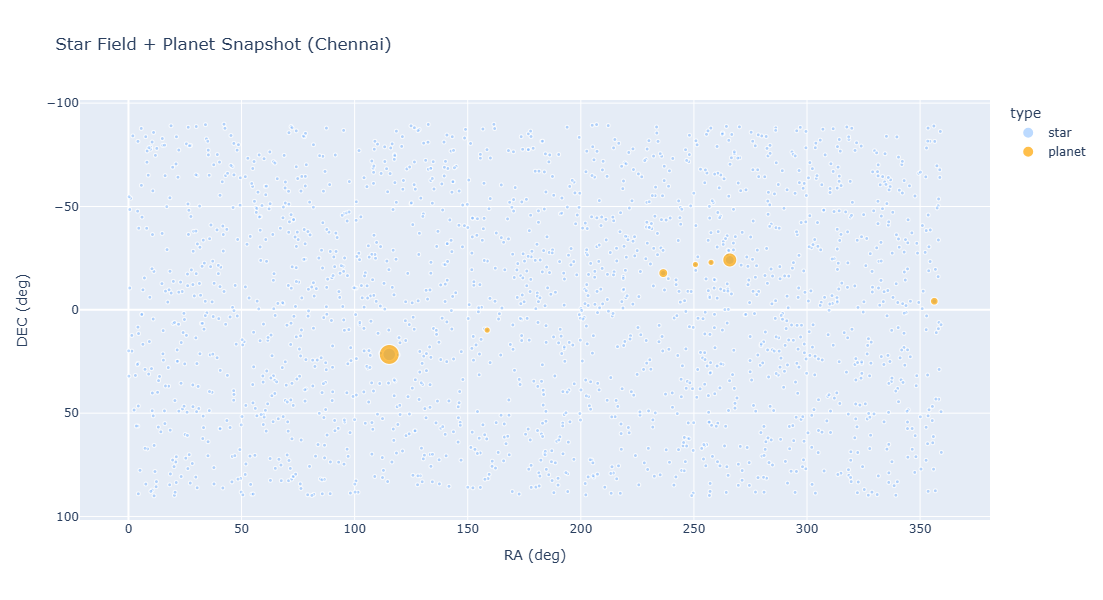

In [6]:
# Cell 6 — safe snapshot plotting helper
def safe_size_from_mag(mag, min_size=2, max_size=20):
    mag = np.array(mag, dtype=float)
    # avoid division by zero or negative
    with np.errstate(divide='ignore', invalid='ignore'):
        size = 10.0 / (mag + 2.5)
    size[np.isnan(size)] = min_size
    size = np.clip(size, min_size, max_size)
    return size

def plot_snapshot_stars_and_planets(star_catalog, planet_records):
    rows = []
    # stars (star_catalog may be list of dicts or merged entries)
    for i, s in enumerate(star_catalog):
        # accept both merged-like and raw star entries
        if isinstance(s, dict) and ("ra_deg" in s or "ra" in s):
            ra = float(s.get("ra_deg", s.get("ra", np.nan)))
            dec = float(s.get("dec_deg", s.get("dec", np.nan)))
            mag = float(s.get("mag", s.get("brightness", np.nan) or 15.0))
        else:
            ra, dec, mag = np.nan, np.nan, 15.0
        rows.append({"ra": ra, "dec": dec, "mag": mag, "type": "star", "label": f"Star {i}"})
    # planets
    for p in planet_records:
        rows.append({
            "ra": float(p.get("ra_deg", np.nan)),
            "dec": float(p.get("dec_deg", np.nan)),
            "mag": float(p.get("approx_mag", np.nan)),
            "type": "planet", "label": (p.get("name") or "").upper()
        })
    df = pd.DataFrame(rows).dropna(subset=["ra","dec"])
    if df.empty:
        print("No data to plot.")
        return
    df["size"] = safe_size_from_mag(df["mag"])
    df.loc[df["type"]=="planet","size"] = df.loc[df["type"]=="planet","size"] * 2.5
    fig = px.scatter(
        df, x="ra", y="dec", color="type", size="size", hover_name="label",
        color_discrete_map={"star": "rgba(120,180,255,0.7)","planet":"orange"},
        height=600, title="Star Field + Planet Snapshot (Chennai)"
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(xaxis_title="RA (deg)", yaxis_title="DEC (deg)")
    fig.show()

plot_snapshot_stars_and_planets(merged, planet_snapshot)


In [7]:
# Cell 7 — satellite TLE loader (if file present)
tle_path = "tle.txt"
sat_df = pd.DataFrame(columns=["name","sat_obj"])
if os.path.exists(tle_path):
    lines = [ln.strip() for ln in open(tle_path).read().splitlines() if ln.strip()!='']
    groups = []
    i = 0
    # find valid triplets (name, line1 startswith '1 ', line2 startswith '2 ')
    while i < len(lines)-2:
        name = lines[i]
        l1 = lines[i+1]
        l2 = lines[i+2]
        if l1.startswith("1 ") and l2.startswith("2 "):
            groups.append((name, l1, l2))
            i += 3
        else:
            i += 1
    print("TLE triplets found:", len(groups))
    sat_list = []
    for (name, l1, l2) in groups:
        try:
            sat = EarthSatellite(l1, l2, name, ts)
            sat_list.append({"name": name, "sat_obj": sat})
        except Exception as e:
            print("Failed to create EarthSatellite for", name, ":", e)
    if sat_list:
        sat_df = pd.DataFrame(sat_list)
    print("Loaded satellites:", len(sat_df))
else:
    print("tle.txt not found in notebook folder — skipping satellites.")


TLE triplets found: 5
Loaded satellites: 5


In [8]:
# Cell 8 — compute planet timeseries and satellite tracks across time grid
START = utc_now_tz()
DURATION_HOURS = 6
N_FRAMES = 40
datetimes, sf_times = make_time_grid(START, duration_hours=DURATION_HOURS, n_frames=N_FRAMES)

# planets_timeseries: dict[name] -> {'ra':[...], 'dec':[...], 'times':[...]}
planets_timeseries = {}
for t_dt in datetimes:
    recs = get_planets_at_time(t_dt)
    for p in recs:
        name = p['name']
        if name not in planets_timeseries:
            planets_timeseries[name] = {"ra":[], "dec":[], "times":[]}
        planets_timeseries[name]["ra"].append(p['ra_deg'])
        planets_timeseries[name]["dec"].append(p['dec_deg'])
        planets_timeseries[name]["times"].append(p['datetime_utc'])

print("Planet time-series generated for:", list(planets_timeseries.keys()))

# satellites: compute tracks if sat_df has satellites
sat_tracks = []
if 'sat_obj' in sat_df.columns and len(sat_df) > 0:
    # observer as Topos on Earth via eph
    if HAS_SKYFIELD:
        earth = eph['earth']
        observer = earth + Topos(latitude_degrees=OBSERVER_LAT, longitude_degrees=OBSERVER_LON, elevation_m=OBSERVER_ELEV_M)
        for idx, row in sat_df.iterrows():
            sat = row['sat_obj']
            track = {"name": row['name'], "ra": [], "dec": [], "times": []}
            for t in sf_times:
                try:
                    astrom = observer.at(t).observe(sat).apparent()
                    ra, dec, dist = astrom.radec()
                    track["ra"].append(float(ra.hours * 15.0))
                    track["dec"].append(float(dec.degrees))
                    track["times"].append(t.utc_iso())
                except Exception:
                    track["ra"].append(np.nan)
                    track["dec"].append(np.nan)
                    track["times"].append(None)
            sat_tracks.append(track)
        print("Satellite tracks computed:", len(sat_tracks))
    else:
        print("Skyfield missing — skipping satellite track computation.")
else:
    print("No satellites loaded or TLE parse failed; skipped satellites.")


Planet time-series generated for: ['sun', 'moon', 'mercury', 'venus', 'mars', 'jupiter', 'saturn']
Satellite tracks computed: 5


In [9]:
# Cell 9 — convert planets_timeseries -> planet_all_frames (list of frames with planet dicts)
planet_all_frames = []
n_frames = len(datetimes)
for fi in range(n_frames):
    frame_rows = []
    for pname, series in planets_timeseries.items():
        ra = series['ra'][fi] if fi < len(series['ra']) else np.nan
        dec = series['dec'][fi] if fi < len(series['dec']) else np.nan
        frame_rows.append({"name": pname, "ra": float(ra), "dec": float(dec)})
    planet_all_frames.append(frame_rows)

# save for reuse
with open("planet_all_frames.json", "w") as f:
    json.dump({"start_utc": START.isoformat(), "frames": planet_all_frames}, f, indent=2)
print("Saved planet_all_frames.json (frames):", len(planet_all_frames))


Saved planet_all_frames.json (frames): 40


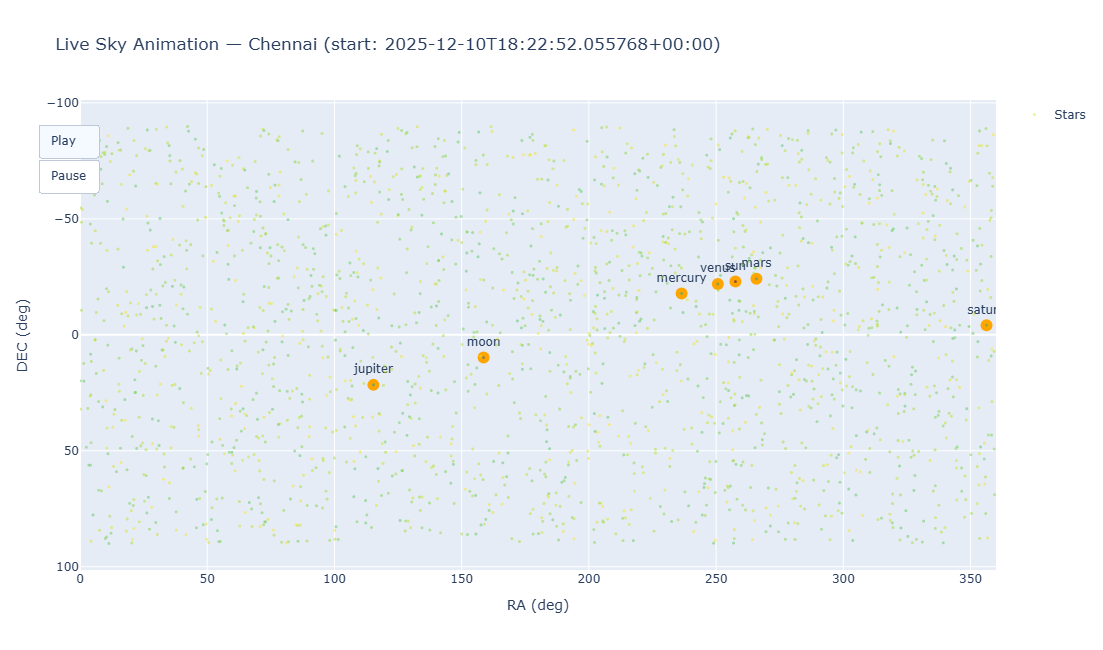

In [10]:
# Cell 10 — Plotly animation builder (static star layer + dynamic planet layer + optional satellites)
# Build static star layer (downsample merged stars for performance)
star_rows = []
if isinstance(merged, list) and len(merged) > 0:
    for s in merged:
        try:
            ra = float(s.get("ra_deg", np.nan))
            dec = float(s.get("dec_deg", np.nan))
            mag = float(s.get("mag", 15.0))
            star_rows.append({"ra": ra, "dec": dec, "mag": mag})
        except Exception:
            continue
star_df = pd.DataFrame(star_rows).dropna()
if len(star_df) > 3000:
    star_df = star_df.sample(n=3000, random_state=1)

# base static traces
base_static = []
if not star_df.empty:
    base_static.append(go.Scattergl(x=star_df["ra"], y=star_df["dec"],
                                    mode="markers",
                                    marker=dict(size=3, color=star_df["mag"], colorscale="Viridis", opacity=0.5, showscale=False),
                                    name="Stars", hoverinfo="none"))
# Milky Way layer (if milky_df exists)
try:
    base_static.append(go.Scattergl(x=milky_df["ra"], y=milky_df["dec"], mode="markers", marker=dict(size=1, opacity=0.4), name="MilkyWay", hoverinfo="none"))
except Exception:
    pass

# create frames
frames = []
for fi in range(len(planet_all_frames)):
    dynamic_traces = []
    # planets
    for p in planet_all_frames[fi]:
        dynamic_traces.append(go.Scatter(x=[p["ra"]], y=[p["dec"]], mode="markers+text", text=[p["name"]], textposition="top center",
                                         marker=dict(size=12, color="orange"), name=p["name"], showlegend=False))
    # satellites for this frame (optional)
    if sat_tracks:
        sat_points = []
        for sat in sat_tracks:
            ra = sat["ra"][fi] if fi < len(sat["ra"]) else np.nan
            dec = sat["dec"][fi] if fi < len(sat["dec"]) else np.nan
            sat_points.append((ra, dec, sat["name"]))
        # add satellite trace if any valid
        sras = [r for r, d, n in sat_points if not np.isnan(r)]
        sdecs = [d for r, d, n in sat_points if not np.isnan(r)]
        snames = [n for r, d, n in sat_points if not np.isnan(r)]
        if sras:
            dynamic_traces.append(go.Scatter(x=sras, y=sdecs, mode="markers+text", text=snames, textposition="bottom center",
                                            marker=dict(size=8, color="lightgreen"), name="Satellites", showlegend=False))
    frame_data = list(base_static) + dynamic_traces
    frames.append(go.Frame(data=frame_data, name=str(fi), layout=go.Layout(title_text=f"UTC: {datetimes[fi].isoformat()}")))

# first frame for display
first_frame = frames[0].data if frames else list(base_static)

fig = go.Figure(data=first_frame, frames=frames)
fig.update_layout(
    title=f"Live Sky Animation — Chennai (start: {START.isoformat()})",
    xaxis=dict(range=[0,360], title="RA (deg)"),
    yaxis=dict(range=[-90,90], title="DEC (deg)", autorange="reversed"),
    height=650,
    updatemenus=[{
        "type":"buttons",
        "buttons":[
            {"label":"Play", "method":"animate", "args":[None, {"frame":{"duration":200, "redraw":True}, "fromcurrent":True}]},
            {"label":"Pause", "method":"animate", "args":[[None], {"frame":{"duration":0, "redraw":False}, "mode":"immediate"}]}
        ],
        "x":0.02, "y":0.95
    }],
    showlegend=True
)
fig.show()


In [11]:
# Cell 11 — small helper exports for dashboard/app.py to import if needed
helpers_path = os.path.join("dashboard", "planet_engine_helpers.py")
os.makedirs("dashboard", exist_ok=True)
with open(helpers_path, "w") as f:
    f.write("# Auto-generated helper: returns latest planet snapshot\n")
    f.write("import json\n")
    f.write("def load_planet_snapshot(fname='planet_catalog.json'):\n")
    f.write("    with open(fname,'r') as f: return json.load(f)\n")
print("Wrote helper to", helpers_path)


Wrote helper to dashboard\planet_engine_helpers.py
